In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from scipy.stats import norm, zscore
from qtl.norm import inverse_normal_transform
from scipy.stats import median_absolute_deviation

import warnings
warnings.filterwarnings('ignore')

sys.path.append('../funcs')

import proteomics as prot
import processing as pp
import plotting as pl
from utils import get_pcs, remove_covariates, plot_pca, plot_pca_gridplot, plot_pca_ax

In [2]:
DATA_DIR = "../data/processed/061721"
PLOTS_DIR = "figures/clustering_prep"
MAPPING_FILE = "../data/processed/061721/PanCan_Participant_freeze_mapping.tsv"

os.makedirs(PLOTS_DIR, exist_ok=True)

## 1. Load Processed Multi-Omic Data
---

In [3]:
prot_df = pd.read_parquet(os.path.join(DATA_DIR, "imputed_res", "proteome_X.parquet"))
phosph_df = pd.read_parquet(os.path.join(DATA_DIR, "imputed_res", "phosphoproteome_X.parquet"))
acetyl_df = pd.read_parquet(os.path.join(DATA_DIR, "imputed_res", "acetylome_X.parquet"))
rna_df = pd.read_parquet(os.path.join(DATA_DIR, "rna", "tumor_rna_tpm_norm_combat_filt_X.parquet"))

In [4]:
samples_df = pd.read_csv(MAPPING_FILE,sep='\t',index_col=0)

In [5]:
prot_samples = np.intersect1d(prot_df.columns, phosph_df.columns)
samples_to_use = np.intersect1d(prot_samples, rna_df.columns)

# Subset for # Samples
rna_df = rna_df[samples_to_use]
prot_df = prot_df[samples_to_use]
phosph_df = phosph_df[samples_to_use]
acetyl_df = acetyl_df[np.intersect1d(samples_to_use, acetyl_df.columns)]

# Cohort Series
meta_s = samples_df[['Proteome_Sample_ID','cohort']].set_index('Proteome_Sample_ID').loc[samples_to_use,'cohort']

In [6]:
rna_z_df = inverse_normal_transform(rna_df)
rna_z_df = rna_z_df - rna_z_df.median(0)
rna_z_df = rna_z_df / median_absolute_deviation(rna_z_df.values)

In [7]:
print("   * {} genes x {} samples".format(*rna_df.shape))
print("   * {} proteins x {} samples".format(*prot_df.shape))
print("   * {} phospho-sites x {} samples".format(*phosph_df.shape))
print("   * {} acetyl-sites x {} samples".format(*acetyl_df.shape))

   * 5000 genes x 1110 samples
   * 5716 proteins x 1110 samples
   * 3341 phospho-sites x 1110 samples
   * 1889 acetyl-sites x 572 samples


## 2. Combine + Visualize
---

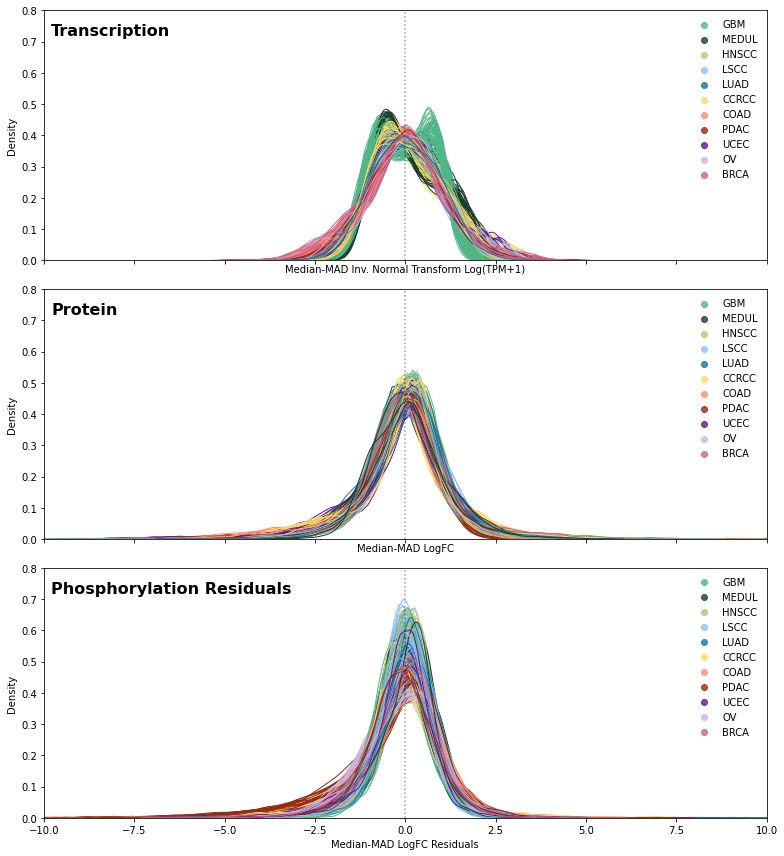

In [8]:
fig,axes = plt.subplots(3,1, figsize=(11,12), sharex=True)

pl.plot_sample_dist(rna_z_df.T, meta_s, ax=axes[0], title='Transcription')
pl.plot_sample_dist(prot_df.T, meta_s, ax=axes[1], title='Protein')
pl.plot_sample_dist(phosph_df.T, meta_s, ax=axes[2], title='Phosphorylation Residuals')

axes[0].set_ylim(0,.8)
axes[1].set_ylim(0,.8)
axes[2].set_ylim(0,.8)

axes[0].set_xlabel("Median-MAD Inv. Normal Transform Log(TPM+1)")
axes[1].set_xlabel("Median-MAD LogFC")
axes[2].set_xlabel("Median-MAD LogFC Residuals")

axes[0].set_ylabel("Density")
axes[1].set_ylabel("Density")
axes[2].set_ylabel("Density")

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "X_pan_sample_dist.pdf"), dpi=300, bbox_inches='tight')

In [9]:
X = pd.concat([
    prot_df,
    phosph_df,
    rna_z_df    
])

print("{} features x {} samples".format(X.shape[0],X.shape[1]))

14057 features x 1110 samples


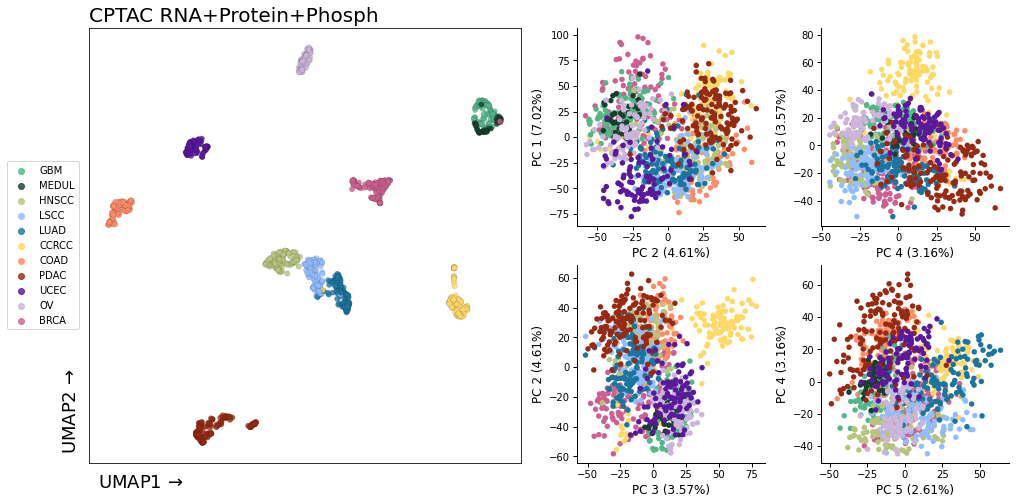

In [10]:
_,_,_,_ = pl.plot_umap_pca_grid(X, meta_s, title='CPTAC RNA+Protein+Phosph')
plt.savefig(os.path.join(PLOTS_DIR, "umap_pca_grid_no_reg.pdf"), dpi=200, bbox_inches='tight')

## 3. Regress out Cohort
---

In [11]:
X_reg = remove_covariates(X, pd.get_dummies(meta_s))
acetyl_reg_df = remove_covariates(acetyl_df, pd.get_dummies(meta_s.loc[acetyl_df.columns]))

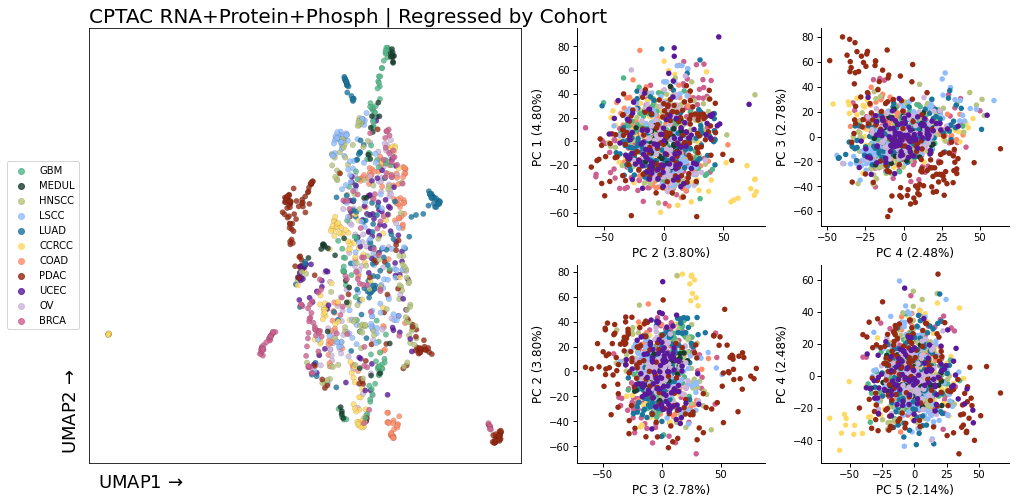

In [12]:
_,_,_,_ = pl.plot_umap_pca_grid(X_reg, meta_s, title='CPTAC RNA+Protein+Phosph | Regressed by Cohort')
plt.savefig(os.path.join(PLOTS_DIR, "umap_pca_grid_reg.pdf"), dpi=200, bbox_inches='tight')

In [ ]:
#X.to_parquet(os.path.join(DATA_DIR, "imputed_res", "pan_X.parquet"))
#X_reg.to_parquet(os.path.join(DATA_DIR, "imputed_res", "pan_reg_X.parquet"))

In [ ]:
pl.plot_sample_dist(X_reg.T, meta_s)
plt.title("Protein+Phospho+RNA Regressed", fontsize=16)
plt.savefig(os.path.join(PLOTS_DIR, "full_reg_sample_dist.pdf"), dpi=200, bbox_inches='tight')

## 4. Save Matrices
---

In [18]:
phosph_df.to_parquet(os.path.join(DATA_DIR, "imputed_res", "phospho_ardnmf_X.parquet"))
phosph_df.to_csv(os.path.join(DATA_DIR, "imputed_res", "phospho_ardnmf_X.tsv.gz"))

prot_df.to_parquet(os.path.join(DATA_DIR, "imputed_res", "prot_ardnmf_X.parquet"))
prot_df.to_csv(os.path.join(DATA_DIR, "imputed_res", "prot_ardnmf_X.tsv.gz"))

rna_z_df.to_parquet(os.path.join(DATA_DIR, "imputed_res", "rna_ardnmf_X.parquet"))
rna_z_df.to_csv(os.path.join(DATA_DIR, "imputed_res", "rna_ardnmf_X.tsv.gz"))

acetyl_df.to_parquet(os.path.join(DATA_DIR, "imputed_res", "acetyl_ardnmf_X.parquet"))
acetyl_df.to_csv(os.path.join(DATA_DIR, "imputed_res", "acetyl_ardnmf_X.tsv.gz"))

In [19]:
phosph_reg_df = remove_covariates(phosph_df, pd.get_dummies(meta_s))
prot_reg_df = remove_covariates(prot_df, pd.get_dummies(meta_s))
rna_z_reg_df = remove_covariates(rna_z_df, pd.get_dummies(meta_s))

In [20]:
phosph_reg_df.to_parquet(os.path.join(DATA_DIR, "imputed_res", "phospho_ardnmf_reg_X.parquet"))
phosph_reg_df.to_csv(os.path.join(DATA_DIR, "imputed_res", "phospho_ardnmf_reg_X.tsv.gz"))

prot_reg_df.to_parquet(os.path.join(DATA_DIR, "imputed_res", "prot_ardnmf_reg_X.parquet"))
prot_reg_df.to_csv(os.path.join(DATA_DIR,  "imputed_res","prot_ardnmf_reg_X.tsv.gz"))

rna_z_reg_df.to_parquet(os.path.join(DATA_DIR, "imputed_res", "rna_ardnmf_reg_X.parquet"))
rna_z_reg_df.to_csv(os.path.join(DATA_DIR, "imputed_res", "rna_ardnmf_reg_X.tsv.gz"))

acetyl_reg_df.to_parquet(os.path.join(DATA_DIR, "imputed_res", "acetyl_ardnmf_reg_X.parquet"))
acetyl_reg_df.to_csv(os.path.join(DATA_DIR, "imputed_res", "acetyl_ardnmf_reg_X.tsv.gz"))

In [22]:
pmap_df = pd.read_csv(os.path.join(DATA_DIR, "var_map.tsv"), sep='\t', index_col=0)
rmap_df = pd.read_csv(os.path.join(DATA_DIR, "rna", "var_map.tsv"),sep='\t', index_col=0).rename(columns={"Description":"geneSymbol"})
rmap_df.index.name = 'id'
rmap_df['feature'] = 'transcriptome'

pmap_df = pd.concat((pmap_df,rmap_df))
pmap_df.to_csv(os.path.join(DATA_DIR, "var_map_full.tsv"),sep='\t')

#### Save Full RNA

In [23]:
rna_df = pd.read_csv(os.path.join(DATA_DIR, "rna", "tumor_rna_tpm_norm_reg_X.tsv.gz"),sep='\t',index_col=0)
map_df = pd.read_csv(os.path.join(DATA_DIR, "rna", "var_map.tsv"),sep='\t',index_col=0)
rna_df = rna_df.loc[np.intersect1d(map_df[map_df['biotype']=='protein_coding'].index, rna_df.index)]

In [24]:
rna_df.to_parquet(os.path.join(DATA_DIR, "rna", "tumor_rna_tpm_norm_reg_pc_X.parquet"))

In [25]:
rna_z_df = inverse_normal_transform(rna_df)
rna_z_df = rna_z_df - rna_z_df.median(0)
rna_z_df = rna_z_df / median_absolute_deviation(rna_z_df.values)

In [26]:
rna_z_df.to_parquet(os.path.join(DATA_DIR, "rna", "tumor_rna_tpm_norm_reg_pc_mmad_int_X.parquet"))

In [28]:
counts_df = pd.read_csv(os.path.join(DATA_DIR, "rna", "tumor_rna_counts_X.tsv.gz"), sep='\t',index_col=0)
gene_name = pd.read_csv(os.path.join(DATA_DIR, "rna", "var_map.tsv"), sep='\t',index_col=0)
counts_df.loc[gene_name[gene_name['biotype']=='protein_coding'].index].to_csv(os.path.join(DATA_DIR, "rna", "tumor_rna_counts_pc_X.tsv"),sep='\t')

## 5. Run ARD-NMF
---

Run `../scripts/ardnmf.sh`